# Table of Contents

1. [Introduction](#Introduction) 
2. [Understanding our dataset](#Understanding-our-dataset)
2. [Training a Binary Classifier](#Training-a-Binary-Classifier)
3. [Performance Measures](#Performance-Measures)
4. [Multiclass Classification](#Multiclass-Classification)
5. [Multilabel Classification](#Multilabel-Classification)
5. [Multioutput Classification](#Multioutput-Classification)
6. [Credits](#Credits)

## Introduction

In this notebook, we will explore the MNIST dataset, which consists of 70,000 images of handwritten digits (0-9) by high school students and employees of the US Census Bureau. We will implement various classification algorithms to recognize these digits and evaluate their performance.

## Understanding our dataset

We fetch MNIST dataset that consists of a set of 70,000 small images of digits handwritten.Each image has 784 features which represent the image pixels that vary from 0 to 255. The image pixels are the ones that identify what digit it is by assigning color to a particular point.

Each image is labeled with the digit it represents , scikit-learn provides many helper functions to download popular datasets. MNIST is one of them.

In [105]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt  # Correct import


In [106]:
# Fetch the MNIST dataset
mnist = fetch_openml("mnist_784", version=1,parser = 'auto')


In [107]:
# Check keys of the dataset
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [108]:

# Extract the data and target labels
X, y = mnist["data"], mnist["target"]


In [109]:

# Check the shape of the data
print(f"X shape :{X.shape}")  # (70000, 784)
print(f"y shape :{y.shape}")  # (70000,)


X shape :(70000, 784)
y shape :(70000,)


In [110]:
# Reshape one image (28x28 pixels)
some_digit = X.iloc[0]  # Access using iloc since X is a DataFrame
some_digit_image = np.array(some_digit).reshape(28, 28)  # Reshape to 28x28


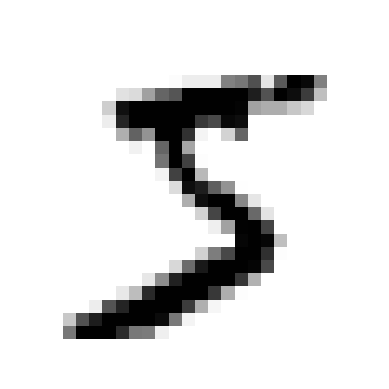

In [111]:

# Display the image using matplotlib
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")  # Turn off the axis
plt.show()

This looks like a 5 , and indeed that's what the label tells us:

In [112]:
y[0]

'5'

Note that the label is a string .Most ML algorithms expect numbers , so let's cast y to integer:

In [113]:
y = y.astype(np.uint8)

But Wait! You should always create a test set and set it aside before inspecting the data closely.

In [114]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Why split that way , the MNIST  dataset is actually already split into a training set (the first 60000 images) and a test set (the last 10000 images)

The training set is already shuffled for us,which is good because this guarantees that all cros-validation folds will be similar(you don't want one fold to be missing some digits).Moreover , some learning algorithms are sensitive tothe order of the training instances ,and they perform porly if they get many similar instances in a row.

## Training a Binary Classifier

[Navigate to the Table of contents](#Table-of-Contents)

Simplifying the problem for now and only try to identify one digit - for example the number 5. 
<br>This "5- detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and no-5.

In [115]:
y_train_5= (y_train == 5) # True for all 5s , False for all other digits
y_test_5 = (y_test == 5)

We'll pick a classifier and train it . Stochastic Gradient Descent (SGD) classifier, using scikit-learn's SGDClassifier class.

This classifier has the advantage of being capable of handling very large dataset efficiently.This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning),as we will see later.

In [116]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42) # relies on randomness hence the name "stochastic"
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [117]:
import pandas as pd
some_digit= pd.DataFrame([some_digit] , columns = X_train.columns) # change some_digit from array to dataframe to avoid errors

In [118]:
sgd_clf.predict(some_digit)

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case!

Now let's evaluate this model's performance.

## Performance Measures

[Navigate to the Table of contents](#Table-of-Contents)

Evaluating a classifier is often significantly trickier than evaluating a regressor.

### Implementing Cross-Validation

Occasionally you will need more control over the cross-validation process that what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself.

In [119]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3 ,random_state =42,shuffle= True)

for train_index , test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier , trains that clone on the training folds, and makes predictions on the test fold. <br> Then it counts the number of correct predictions and outputs the ration of correct predictions

Recall that we don't want to touch our test set before we evaluate our model. Thus we split the training dataset into K folds.

Remember that K fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold
 using a model trained on the remaining folds.

In [120]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train,y_train_5 , cv =3 , scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 93% accuracy (ratio of correct predictions) on all cross -validation folds?
This looks amazing , doesn't it? Well , before you get too excited , let's look at a very dumb classifier that just classifies every single image in the "not-5" class.

In [121]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype = bool)

In [122]:
# Finding this model's accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train , y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That's right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s , so if you always guess that an image is not a 5,you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)

### Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B. <br>For example , to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix. 

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. 
Remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch. 

<br>Instead, you can use the cross_val_predict() function:

In [123]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train , y_train_5 , cv =3 )

just like cross_val_score() function, the cross_val_predict() performs K-fold cross-validation,but instead of returning the evaluation scores, it return the predictions made on each test fold.

In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an **actual class**, while each column represents a **predicted class**.

The first row of this matrix considers non-5 images (the *negative class*): 53892 of them were correctly classified as non-5s (they are called *true negatives*), while the remaining 687 were wrongly classified as 5s(*false positives*).<br>

The second row considers the images of 5s(the *positive class*): 1891 were wrongly classified as non-5s (*false negatives*), while the remaining 35301 were correctly classified as 5s (*true positives*).    


A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [125]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the <italic>precision of the classifier</italic>

$$\begin{eqnarray*}
precision =  \frac{TP}{TP + FP}
\end{eqnarray*}$$

$\text{TP}$ is the number of true positives, and $\text{FP}$ is the number of false positives.

So precision is typically used along with another metric named **recall**, also called **sensitivity** or the **true positive rate(TPR)**: This is the ratio of positive instances that are correctly detected by the classifier

$$
\begin{eqnarray}
recall = \frac{TP}{TP + FN}
\end{eqnarray}
$$

${FN}$ is, of course, the number of false negatives.

$$
\begin{array}{|c|c|c|}
\hline
\text{Actual \\ Predicted} & \text{Negative} & \text{Positive} \\
\hline
\text{Negative} & \text{TN} & \text{FP} \\
\hline
\text{Positive} & \text{FN} & \text{TP} \\
\hline
\end{array}
$$

### Precision and Recall 

In [126]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred) # == 35301 / (35301 + 687)

0.8370879772350012

In [127]:
recall_score(y_train_5, y_train_pred) # == 35301 / (35301 + 1891 )

0.6511713705958311

Now your  5-detector does not look as shiny as it did when you looked at its accuracy.<br> When it claims an image represents a 5, it is correctly only 65.1% of the time. Moreover, it only detects 83.7% of the 5s.

Combining precision and recall into a single metric called the F_1 score , in particular if you need a simple way to compare two classifiers.

The F_1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally , the harmonic mean gives much more weight to low values.

As a result, the classifier will only get a high F_1 score if both recall and precision are high.

$$
\begin{eqnarray}
F1 =\frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 * \frac{precision *  recall}{precision + recall } = \frac{TP}{TP + \frac{FN + FP}{2}}
\end{eqnarray}
$$

In [128]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

 The F_1 score favors classifiers that have similar precision and recall.

Unfortunately, you can’t have it both ways: increasing precision reduces
 recall, and vice versa. This is called the **precision/recall trade-off**

### Precision / Recall Trade-off

Looking at SGDClassifier ,it computes a score based on a *decision function.*
If that score is greater than a threshfold , it assign the instance to the positive class; otherwise it assign it to the negative class.

Suppose the **decision threshold** is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6).
    
Therefore , with that threshold , the precision is 80% (4 out of 5).But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6).
If
 you raise the threshold (move it to the arrow on the right), the false positive
 (the 6) becomes a true negative, thereby increasing the precision (up to
 100% in this case), but one true positive becomes a false negative,
 decreasing recall down to 50%. Conversely, lowering the threshold
 increases recall and reduces precision

<img src="./precision&recalldemo_ml.jpeg" alt="Alt Text" style="width:800px;"/>

Scikit-Learn does not let you set the threshold directly , but it does give you access to the decision scores that it uses to make predictions.
<br> Instead of calling the classifier's **predict()** method, you can call its **decision_function()** method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [129]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([2164.22030239])

In [130]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0 , so the previous code returns the same result as the predict() method(i.e., True)

Let's raise the threshold:

In [131]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall . The image actually represents a 5 ,and the classifier detects it when the threshold is 0 ,but it misses it when the threshold is increased to 8000

#### Deciding which threshold to use?

First, use the cross_val_predict() function to get the scores of all instances in the training ser, but this time specify that you want to return decision scores instead of predictions:

In [132]:
y_scores = cross_val_predict(sgd_clf , X_train,y_train_5, cv=3, method="decision_function")

In [133]:
# with these scores use precision_recall_curve() function to compute precision and recall for all possible thresholds:
from sklearn.metrics import precision_recall_curve
precisions, recalls ,thresholds = precision_recall_curve(y_train_5,y_scores)

Finally , use matplotlib to plot precision and recall as functions of the threshold  value

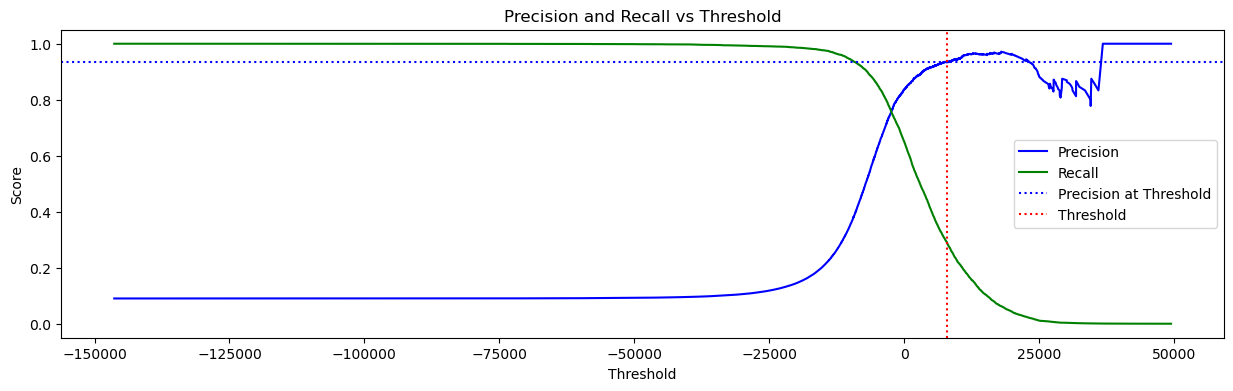

In [134]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold):
    fig,ax = plt.subplots(figsize=(15,4))
    # Plot Precision and Recall against Threshold
    ax.plot(thresholds, precisions[:-1], "b-", label="Precision")
    ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
    # find the index of the threshold 
    threshold_index = next(i for i , t in enumerate(thresholds) if t>= threshold)
    precision_at_threshold = precisions[threshold_index]
    recall_at_threshold = recalls[threshold_index]
    # Add horizontal lines for precision and recall at the threshold
    ax.axhline(y=precision_at_threshold, color = "b", ls = ":", label = "Precision at Threshold")
    
    # Highlight the specified threshold with a vertical line
    ax.axvline(x=threshold, color='r', linestyle=':', label='Threshold')
    #ax.sextxlimit(-50000 , 50000)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title("Precision and Recall vs Threshold")
    ax.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall.

#### Precision/ Recall (PR) curve

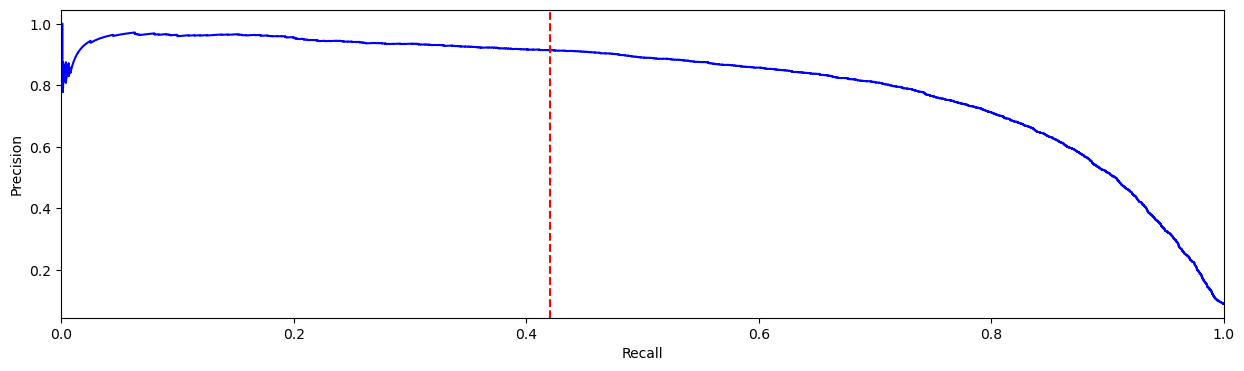

In [135]:
fig,ax = plt.subplots(figsize = (15,4))
ax.plot(recalls, precisions,"b-")
ax.axvline(x=0.42,c="r",ls="--")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0,1)
plt.show()

The precision starts to fall sharply around 80% recall. You will probably want to select a precision/recall trade-off just before that drop - for example , at around 60%.

Suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 8,000. To be more precise you can search for the lowest threshold that gives you at least 90% precision.(np.argmax() will give you the first index of the maximum valu, which in this case means the first True value):

In [136]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]#~3370

To make predictions (on the training set for now),instead of calling the classifier's predict() method, you can run this code:

In [137]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [138]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [139]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! A high-precision classifier is not very useful if its recall is too low!

#### The ROC Curve

The *receiving operating characteristic* (ROC) curve is another common tool used with binary classifiers.

Similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the *true positive rate(another name for recall) against the *false positive rate(FPR)**

The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1- the *true negative rate(TNR)*, which is the ratio of negative instances classified as negative.

The TNR is also called *specificity*.Hence the ROC curve plots *sensitivity* (recall) versus 1- *specificity*.

In [140]:
from sklearn.metrics import roc_curve #using roc_curve function to compute the TPR and FPR for various threshold values:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

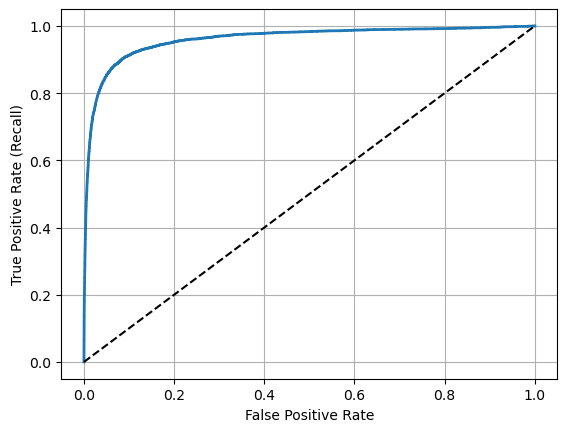

In [141]:
# then you can plot the FPR against the TPR using Matplotlib
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr ,linewidth = 2 , label = label)
    plt.plot([0,1],[0,1],'k--') #Dashed diagonal
    plt.grid(True)
    plt.xlabel("False Positive Rate") # Add axis labels and grid
    plt.ylabel("True Positive Rate (Recall)")
    
plot_roc_curve(fpr,tpr)
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)

One way to compare classifiers is to measure the area under the curve(AUC).

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [142]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Note

Since the ROC curve is so similar to the precion/recall(PR) curve, you may wonder how to decide which one to use. 

**As a rule of thumb**,you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise use the ROC curve.

Looking at our ROC curve (and the ROC AUC score) you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast , the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner)

##### Comparing the same with the RandomForestClassifier

In [143]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state =42)
y_probas_forest = cross_val_predict(forest_clf, X_train , y_train_5, cv = 3, method = "predict_proba") # we use this method since random forest classifier lack the decision_function() method. 

The roc_curve() function expects labels and scores, but instead of scores you can give it class probabilites. 

In [144]:
# using the positive class's probability as the score
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest , tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

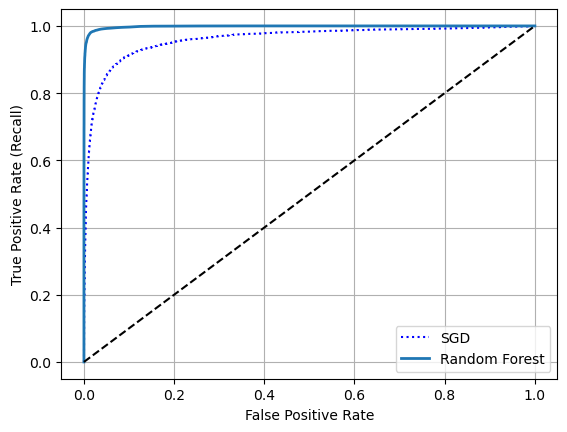

In [145]:
# plotting the first ROC curve as well to see how they compare
plt.plot(fpr, tpr ,"b:", label ="SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As you can see, the Random Forest Classifier is superior to & looks much better than the SGD classifier because its ROC curve is much close to the top-left corner, and it has a greater AUC

In [146]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [147]:
from sklearn.metrics import precision_score , recall_score
# since y_scores_forest is continous with probabilities , changing it to binary 
y_scores_forest_bin = (y_scores_forest>=0.5)
precision_score(y_train_5,y_scores_forest_bin)

0.9897468089558485

In [148]:
recall_score(y_train_5,y_scores_forest_bin)

0.8725327430363402

Measuring the precision and recall scores: you should find 99.0% precision and 87% recall .Not too bad!

Let's try detecting more than just the 5s.[Multiclass Classification](#Multiclass-Classification)

## Multiclass Classification

[Navigate to the Table of contents](#Table-of-Contents)

Binary classifiers distinguish between two classes , *multiclass classifiers* (also called *multinomial classifiers*) can distinguish between more than two classes.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers , one for each digit (a 0-detector, a 1-detector,a 2-detector, and so on)Then when you want to classify an
 image, you get the decision score from each classifier for that image and
 you select the class whose classifier outputs the highest score. This is called
 the *one-versus-the-rest* (OvR) strategy (also called *one-versus-all*)

Another strategy is to train a binary classifie for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s , another for 1s and 2s , and so on. This is called the *one-versus-one* (OvO) strategy. If there are N classes, you need to train *N * (N-1)/2* classifiers.

For the MNIST problem , this means training 45 binary classifiers!
When you want  to classify an image , you have to run the image through all 45 classifiers and see which class wins the mosts duels.
The main advantage of OvO  is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set.For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets.

For most binary classification algorithms, however, OvR, is preferred

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task and it automatically runs OvR or OvO, depending on the algorithm .

In [151]:
# trying a support vector machine classifier
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train , not y_train_5
svm_clf.predict(some_digit)

array([5], dtype=uint8)

In [152]:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score  is indeed the one corresponding to class 5. (remember it is classifying 0 to 9)

In [153]:
np.argmax(some_digit_scores)

5

In [154]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [155]:
svm_clf.classes_[5]

5

##### Warning

When a classifier is trained , it stores the list of target classes in its **classes_** attribute, ordered by value.

In this case, the index of each class in the **classes_** array conveniently matches the class itself (e.g, the class at index 5 happens to be class 5), but in general you won't be so lucky.

To force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOnceClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier).

In [156]:
# creating a multiclass classifier using the OvR strategy, based on an SVC:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict(some_digit)

array([5], dtype=uint8)

In [159]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier (or a RandomForestClassifier) is just as easy:

In [174]:
forest_clf.fit(X_train,y_train)
forest_clf.predict(some_digit)

array([5], dtype=uint8)

This time scikit-learn did not have to run OvR or OvO  because SGD classifiers can directly  classify instances into multiple classes. The decision_function() method now returns one value per class.

In [176]:
forest_clf.predict_proba(some_digit) # score that the SGD classifier assigned to  each class

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

You can see that the classifier is fairly confident about its prediction: almost all scores probabilities are nearly zero ,while class 5 has a score of 0.9.

Unfortunately , for my sgdclassifier , it wrongly classified some_digit as 3, to try testing the sgdclassifier ; fit it to the training set and predict some_digit.

In [178]:
cross_val_score(forest_clf,X_train , y_train,cv =3, scoring="accuracy")

array([0.9646 , 0.96255, 0.9666 ])

Nevertheless ,evaluating our SGDClassifier's accuracy , it gets over 96% on all test folds. We cab still do much better simply scaling the inputs.

In [182]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3,scoring = "accuracy")

array([0.96445, 0.96255, 0.96645])

Our SGDClassifier's accuracy has maintained .

#### Error Analysis 

Steps to follow in my Machine learning real project :
<ul>
    <li>Explore data preparation options,</li> 
            <li>try out multiple models (shortlisting the best ones andfine-tuning their hyperparameters using GridSearchCV),</li>
    <li>automate as much as possible</li>
    </ul>

Assuming we have found a promising model and want to find ways to improve it.One way to do this is to analyze the types of errors it makes.

In [180]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled , y_train , cv =3)
conf_mx = confusion_matrix(y_train , y_train_pred)
conf_mx

array([[5840,    1,    8,    2,    4,    9,   20,    1,   35,    3],
       [   1, 6634,   43,   12,   13,    5,    6,   13,   12,    3],
       [  26,   12, 5749,   29,   32,    5,   20,   37,   42,    6],
       [   7,    7,   93, 5809,    3,   63,    7,   49,   61,   32],
       [  12,   13,   14,    1, 5643,    0,   29,   14,   17,   99],
       [  20,    9,    9,   65,   13, 5195,   53,    6,   32,   19],
       [  25,   11,    5,    0,   12,   45, 5805,    0,   15,    0],
       [   4,   24,   58,    6,   37,    1,    0, 6037,   11,   87],
       [   9,   35,   44,   53,   26,   52,   27,    5, 5524,   76],
       [  21,   10,   13,   76,   75,   15,    3,   58,   45, 5633]],
      dtype=int64)

As there is a lot of numbers it's often more convenient to look at  an image representation of the confusion matrix, using Matplotlib's matshow() function:


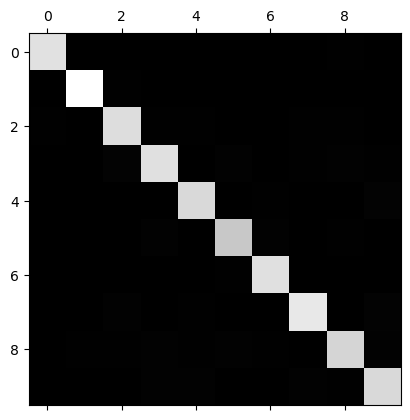

In [181]:
plt.matshow(conf_mx , cmap = plt.cm.gray)
plt.show()

Looks pretty good , since most images are on the main diagonal ,which means that they were classified correctly.

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.

Plotting on the errors:
    <ul>
    <li>First , you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors</li>
   

In [187]:
row_sums =conf_mx.sum(axis =1, keepdims = True)
norm_conf_mx = conf_mx / row_sums


<li>Fill the diagonal with zeros to keep only the errors, and plot the result</li></ul>

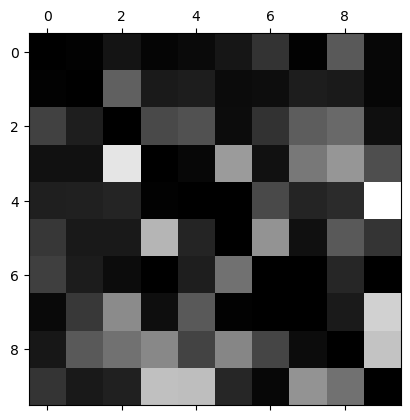

In [192]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

Rows represent actual classes , while columns represent predicted classes. 

The column for class 8 is quite bright , which tells you that many images get misclassified as 8s.

However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s.

You can also see that 3s and 5s often get confused (in both directions).Also 9 and 4s 

To improve the classifier , we could try to gather more training data for digits that look like 8s(but are not) so that the classifier can learn to distinguish them from real 8s.Or you could engineer  new features that would help the classifier - for example , writing an algorithm to count the number of closed loops (e.g., 8 has two , 6 has one , 5 has none). Or you could preprocess the images (e.g., using Scikit-Image , Pillow , or OpenCV) to make some patterns , such as  closed loops , stand out more.

Analysing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming.i.e Let's plot examples of 3s and 5s

## Multilabel Classification

[Navigate to the Table of contents](#Table-of-Contents)

In cases where you may want your classifier to output multiple classes for each instance.

Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. 

Looking at a simpler example:

In [232]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==  1)
y_multilabel = np.c_[y_train_large , y_train_odd]


knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

This code creates a y_multilable array containing two target labels for each digit image: the first indicates whether or not the digit is large (7,8 or 9),and the second indicates whether or not it is odd.

The next lines create a KNeighborsClassifier instance (which supports multilabel classificaaion , though not all classifiers do), train it using the multiple targets array.Now ,we canc make a prediction.

In [236]:
knn_clf.predict(some_digit)

array([[False,  True]])

It outputs two labels and it gets it right! The digit 5 indeed not large(False) and odd (True)

In [238]:
#Evaluating the multilabel classifier using the F_1 score
y_train_knn_pred =cross_val_predict(knn_clf, X_train,y_multilabel, cv =3)
f1_score(y_multilabel,y_train_knn_pred, average ="macro")

0.976410265560605

## Multioutput Classification

[Navigate to the Table of contents](#Table-of-Contents)

Also called *multioutput- multiclass classification*. It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this by building a system that removes noice from images. taking as input a noisy digit image , and it will hopefully output a clean digit image,represented as an array of pixel intensities , just like the MNIST images.

In [241]:
#creating the training and test sets by taking the MNIST images and adding noise to their pixes intensities with Numpy's randint()
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 
y_train_mod = X_train
y_test_mod = X_test

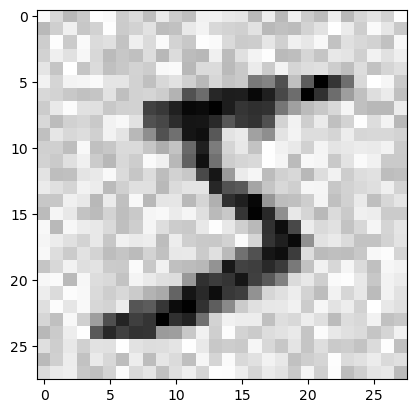

In [246]:

plt.imshow(X_train_mod.iloc[0].values.reshape(28,28),cmap="binary")
plt.show()

Taking a peek at an image from the test set, this is the some_digit image at the start of our classification conversation

Now let's train the classifier and make it clean these images

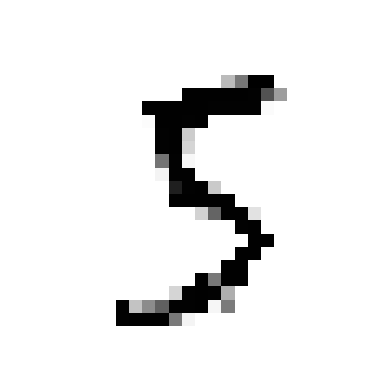

In [272]:
knn_clf.fit(X_train_mod, y_train_mod)
#isolating the some_digit noised image for prediction
some_digit_noised = pd.DataFrame(X_train_mod.iloc[0]).T
clean_digit = knn_clf.predict(some_digit_noised)
plt.imshow(clean_digit.reshape(28,28),cmap="binary")
plt.axis("off")
plt.show()

Looks close enough to the target!Concluding our tour of classification on this jupyter notebooks.

## Credits

[Navigate to the Table of contents](#Table-of-Contents)


<ul>
    <li><b>Hands-On Machine Learning
 with Scikit-Learn, Keras, and
 TensorFlow ; Aurelion Geron</b> </li>Making it possible for me to make this notebook by following his examples and teaching side by side.</ul>